# Stability and Performance of Wind-Aware Path Following Guidance for Small Fixed-Wing Aircraft
Author: Thomas Stastny ([tstastny@ethz.ch](mailto:tstastny@ethz.ch))

This notebook contains scripts useful for the analysis of stability properties for a wind-aware nonlinear differential geometric path following guidance law for small fixed-wing unmanned aircraft.

In [1]:
# sympy
import sympy as sp
from IPython.display import display, Math
sp.init_printing()

# numpy
import numpy as np

# scipy
from scipy import optimize

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.style.use('seaborn-whitegrid')
plt.rcParams.update({"text.usetex": True})
plt.rcParams.update({'legend.frameon': True,
                     'legend.framealpha': 1,
                     'legend.facecolor': 'white',
                     'axes.titlesize': 20,
                     'axes.labelsize': 16,
                     'legend.fontsize': 14,
                     'axes.edgecolor': 'black'})

# Symbolic Derivation

## Wind-Aware Control Law

In [2]:
k = sp.symbols('k', real=True, positive=True)
T = sp.symbols('T', real=True, positive=True)
vGP = sp.symbols('v_{G\,P}', real=True, positive=True)
xP = sp.symbols('x_P', real=True)
vA = sp.symbols('v_A', real=True, positive=True)
vW = sp.symbols('v_W', real=True, positive=True)
kapP = sp.symbols('\\kappa_P', real=True, positive=True)
lP = sp.symbols('\\lambda_P', real=True)

# ground to air projection speed ratio
a = sp.symbols('a', real=True)
a_expr = vGP / vA / sp.cos(xP)

# wind-modulated turn rate
b = sp.symbols('b', real=True)
b_expr = vGP * kapP * sp.tan(xP)

# linearized on-track dynamics
d_etadot_d_eta = sp.symbols('\\cfrac{\\partial\\dot{\\eta}}{\\partial\\eta}')
d_etadot_d_beta = sp.symbols('\\cfrac{\\partial\\dot{\\eta}}{\\partial\\beta}')
d_betadot_d_eta = sp.symbols('\\cfrac{\\partial\\dot{\\beta}}{\\partial\\eta}')
d_betadot_d_beta = sp.symbols('\\cfrac{\\partial\\dot{\\beta}}{\\partial\\beta}')
d_etadot_d_eta_expr = -k + sp.pi/T
d_etadot_d_beta_expr = a * ( b - sp.pi / T )
d_betadot_d_eta_expr = sp.pi / T / a
d_betadot_d_beta_expr = b - sp.pi / T

print('Jacobian:')
display(Math('%s = %s' %(sp.latex(d_etadot_d_eta), sp.latex(d_etadot_d_eta_expr.subs({b:b_expr,a:a_expr})))))
display(Math('%s = %s' %(sp.latex(d_etadot_d_beta), sp.latex(d_etadot_d_beta_expr.subs({b:b_expr,a:a_expr})))))
display(Math('%s = %s' %(sp.latex(d_betadot_d_eta), sp.latex(d_betadot_d_eta_expr.subs({b:b_expr,a:a_expr})))))
display(Math('%s = %s' %(sp.latex(d_betadot_d_beta), sp.latex(d_betadot_d_beta_expr.subs({b:b_expr,a:a_expr})))))

print('Collect terms:')
display(Math('%s = %s' %(sp.latex(a), sp.latex(a_expr))))
display(Math('%s = %s' %(sp.latex(b), sp.latex(b_expr))))

print('Condensed Jacobian:')
AMatrix = sp.Matrix([[d_etadot_d_eta, d_etadot_d_beta], [d_betadot_d_eta, d_betadot_d_beta]])
AMatrix_expr = sp.Matrix([[d_etadot_d_eta_expr, d_etadot_d_beta_expr], [d_betadot_d_eta_expr, d_betadot_d_beta_expr]])

display(Math('%s = %s' %(sp.latex(AMatrix), sp.latex(AMatrix_expr))))


Jacobian:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Collect terms:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Condensed Jacobian:


<IPython.core.display.Math object>

In [3]:
# characteristic equation
s = sp.symbols('s')
s_m_A = sp.Matrix([[s,0],[0,s]]) - AMatrix_expr
char_eq = s_m_A.det()

print('Characteristic equation:')
# display(expand(char_eq))

# collect coeffs
char_eq_poly = sp.poly(char_eq, s)
char_eq_coeffs = char_eq_poly.coeffs()

display(Math('%s + (%s)s + (%s)' %(sp.latex(s**2),
                                   sp.latex(sp.expand(char_eq_coeffs[1])),
                                   sp.latex(sp.expand(char_eq_coeffs[2])))))

# natural frequency
print('Natural frequency:')
omn = sp.symbols('\\omega_n')
omn_expr = sp.sqrt(sp.expand(char_eq_coeffs[2]))
display(Math('%s = %s' %(sp.latex(omn), sp.latex(omn_expr))))

# damping ratio
print('Damping ratio:')
zeta = sp.symbols('\\zeta')
zeta_expr = sp.simplify(sp.expand(char_eq_coeffs[1] / 2 / omn_expr))
display(Math('%s = %s' %(sp.latex(zeta), sp.latex(zeta_expr))))

Characteristic equation:


<IPython.core.display.Math object>

Natural frequency:


<IPython.core.display.Math object>

Damping ratio:


<IPython.core.display.Math object>

In [4]:
# nominal gains (zero wind case)

om0 = sp.symbols('\\omega_0', positive = True, real = True)
zeta0 = sp.symbols('\\zeta_0', positive = True, real = True)

k0 = sp.symbols('k_0', positive = True, real = True)
k0_expr = 2 * zeta0 * om0
display(Math('%s = %s' %(sp.latex(k0), sp.latex(k0_expr))))

T0 = sp.symbols('T_0', positive = True, real = True)
T0_expr = 2 * sp.pi / om0 * zeta0
display(Math('%s = %s' %(sp.latex(T0), sp.latex(T0_expr))))

# plug in and confirm it works when wind freq = 0
display(Math('%s(%s=%s,%s=%s,%s=0) = %s = %s' %(sp.latex(omn),sp.latex(k),sp.latex(k0), \
                                                sp.latex(T),sp.latex(T0),sp.latex(b), \
                                                sp.latex(omn_expr.subs({b:0, k:k0, T:T0})), \
                                                sp.latex(omn_expr.subs({b:0, k:k0_expr, T:T0_expr})))))
display(Math('%s(%s=%s,%s=%s,%s=0) = %s = %s' %(sp.latex(zeta),sp.latex(k),sp.latex(k0), \
                                                sp.latex(T),sp.latex(T0),sp.latex(b), \
                                                sp.latex(zeta_expr.subs({b:0, k:k0, T:T0})), \
                                                sp.latex(zeta_expr.subs({b:0, k:k0_expr, T:T0_expr})))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Period and Damping in Terms of Nominal Tuning

In [5]:
# subtitute nominal tuning

# Period
P0 = sp.symbols('P_0')

P = sp.symbols('P')
P_expr = 2 * sp.pi / omn_expr

print('Period')

display(Math('%s = %s' %(sp.latex(P), sp.latex(P_expr))))

P_expr_sub = P_expr.subs({k:k0_expr.subs(om0, 2 * sp.pi / P0), T:T0_expr.subs(om0, 2 * sp.pi / P0)})

display(Math('%s = %s' %(sp.latex(P), sp.latex(P_expr_sub))))

# Damping ratio

print('Damping Ratio:')

display(Math('%s = %s' %(sp.latex(zeta), sp.latex(zeta_expr))))

zeta_expr_sub = zeta_expr.subs({k:k0_expr.subs(om0, 2 * sp.pi / P0), T:T0_expr.subs(om0, 2 * sp.pi / P0)})

display(Math('%s = %s' %(sp.latex(zeta), sp.latex(zeta_expr_sub))))

Period


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Damping Ratio:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Wind Factor

In [6]:
alpW = sp.symbols('\\alpha_W')

fW = sp.symbols('f_W')
fW_expr = alpW**2 * sp.sin(lP) * sp.cos(lP) / sp.sqrt(1 - alpW**2 * sp.sin(lP)**2) + alpW * sp.sin(lP)
display(Math('%s = %s' %(sp.latex(fW), sp.latex(fW_expr))))

b_expr_fW = vA * kapP * fW
display(Math('%s = %s = %s' %(sp.latex(b), sp.latex(b_expr_fW), sp.latex(b_expr_fW.subs(fW,fW_expr)))))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Ground Speed Based Control Law
For *straight* paths, $\kappa_P=0$

In [7]:
# ground speed based control law

omP = sp.symbols('\\omega_P')

d_etadot_d_eta_gsp_expr = -k/a + sp.pi/T + kapP * vW * sp.sin(lP) * (a - 1)
d_etadot_d_beta_gsp_expr = a * ( b * (vGP - 2) - sp.pi / T ) + b + omP**2 * T / sp.pi * (1 - a)
d_betadot_d_eta_gsp_expr = sp.pi / T / a
d_betadot_d_beta_gsp_expr = b - sp.pi / T

print('Jacobian:')
display(Math('%s = %s' %(sp.latex(d_etadot_d_eta), sp.latex(d_etadot_d_eta_gsp_expr.subs({b:b_expr,a:a_expr})))))
display(Math('%s = %s' %(sp.latex(d_etadot_d_beta), sp.latex(d_etadot_d_beta_gsp_expr.subs({b:b_expr,a:a_expr})))))
display(Math('%s = %s' %(sp.latex(d_betadot_d_eta), sp.latex(d_betadot_d_eta_gsp_expr.subs({b:b_expr,a:a_expr})))))
display(Math('%s = %s' %(sp.latex(d_betadot_d_beta), sp.latex(d_betadot_d_beta_gsp_expr.subs({b:b_expr,a:a_expr})))))

print('Condensed Jacobian:')
AMatrix_gsp_expr = sp.Matrix([[d_etadot_d_eta_gsp_expr, d_etadot_d_beta_gsp_expr], [d_betadot_d_eta_gsp_expr, d_betadot_d_beta_gsp_expr]])

display(Math('%s = %s' %(sp.latex(AMatrix), sp.latex(AMatrix_gsp_expr))))

# characteristic equation
s_m_A_gsp = sp.Matrix([[s,0],[0,s]]) - AMatrix_gsp_expr
char_eq_gsp = s_m_A_gsp.det()

print('Characteristic equation:')
# display(expand(char_eq_gsp))

# collect coeffs -- straight paths
char_eq_gsp_poly = sp.poly(char_eq_gsp, s)
char_eq_gsp_coeffs = char_eq_gsp_poly.coeffs()

display(Math('%s + (%s)s + (%s)' %(sp.latex(s**2),
                                   sp.latex(sp.expand(char_eq_gsp_coeffs[1].subs({kapP:0, b:0, omP:0}))),
                                   sp.latex(sp.expand(char_eq_gsp_coeffs[2].subs({kapP:0, b:0, omP:0}))))))

# natural frequency
print('Natural frequency:')
omn = sp.symbols('\\omega_n')
omn_gsp_expr = sp.sqrt(sp.expand(char_eq_gsp_coeffs[2].subs({kapP:0, b:0, omP:0})))
display(Math('%s = %s' %(sp.latex(omn), sp.latex(omn_gsp_expr))))

# damping ratio
print('Damping ratio:')
zeta = sp.symbols('\\zeta')
zeta_gsp_expr = sp.simplify(sp.expand(char_eq_gsp_coeffs[1].subs({kapP:0, b:0, omP:0}) / 2 / omn_gsp_expr))
display(Math('%s = %s' %(sp.latex(zeta), sp.latex(zeta_gsp_expr))))

# nominal tuning
print('At nominal tuning:')

# period
print('Period:')
P_gsp_expr_sub = 2 * sp.pi / omn_gsp_expr.subs({k:k0_expr.subs(om0, 2 * sp.pi / P0), T:T0_expr.subs(om0, 2 * sp.pi / P0)})
# modify... 
P_gsp_expr_sub = P0 * sp.sqrt(a)
display(Math('%s = %s' %(sp.latex(P), sp.latex(P_gsp_expr_sub))))

# damping ratio
print('Damping ratio:')
zeta_gsp_expr_sub = sp.simplify(zeta_gsp_expr.subs({k:k0_expr.subs(om0, 2 * sp.pi / P0), T:T0_expr.subs(om0, 2 * sp.pi / P0)}))
# modify... 
zeta_gsp_expr_sub = zeta0 / sp.sqrt(a)
display(Math('%s = %s' %(sp.latex(zeta), sp.latex(zeta_gsp_expr_sub))))

Jacobian:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Condensed Jacobian:


<IPython.core.display.Math object>

Characteristic equation:


<IPython.core.display.Math object>

Natural frequency:


<IPython.core.display.Math object>

Damping ratio:


<IPython.core.display.Math object>

At nominal tuning:
Period:


<IPython.core.display.Math object>

Damping ratio:


<IPython.core.display.Math object>

# Numerical Evaluation

## Check the Solutions...

In [8]:
# helpful functions

def evalb(kapP, lP, vA, vW):
    xP = np.arcsin(vW/vA * np.sin(lP))
    psiP = lP + xP
    vGP = np.sqrt(vA**2 + vW**2 - 2*vA*vW*np.cos(np.pi - psiP))
    return kapP * vGP * np.tan(xP)

# Check the developed Jacobian

def evalJac(k, T, kapP, lP, vA, vW):
    
    # n = 0
    # b = 0
    
    xP = np.arcsin(vW/vA * np.sin(lP))
    psiP = lP + xP
    vGP = np.sqrt(vA**2 + vW**2 - 2*vA*vW*np.cos(np.pi - psiP))
    
    a11 = -k + np.pi/T
    a12 = vGP**2 * kapP * np.tan(xP) / vA / np.cos(xP) - vGP / vA / np.cos(xP) * np.pi / T
    a21 = np.pi / T * vA * np.cos(xP) / vGP
    a22 = vGP * kapP * np.tan(xP) - np.pi / T

    return np.array([a11, a12, a21, a22])


def evalDyn(n, b, k, T, kapP, lP, vA, vW):
    
    ll = b + lP
    
    xl = np.arcsin(vW / vA * np.sin(ll))
    
    psi = b - n + lP + xl
    
    vG = np.sqrt(vA**2 + vW**2 - 2*vA*vW*np.cos(np.pi - psi))
    
    x = np.arccos((vA**2 - vW**2 + vG**2) / (2 * vA * vG))
    
    n_P = n - b + x - xl
    
    vGl = vW * np.cos(ll) + vA * np.cos(xl)
    
    e = -b * vG * T / np.pi
    
    omP = kapP * vG * np.cos(n_P) / (1 - kapP * e)
    
    psidot = k * np.sin(n) + vGl / vA / np.cos(xl) * omP
    
    vGdot = -vA*vW*np.sin(psi) / vG * psidot
    
    bdot = -b * vGdot / vG + np.pi / T * np.sin(n_P)
   
    ndot = -psidot + vGl / vA / np.cos(xl) * (bdot + omP)

    return ndot, bdot


def evalNumJac(n0, b0, k, T, kapP, lP, vA, vW):
    
    dn = 0.000001
    db = 0.000001
    twod = dn*2

    dndot_dn_p, dbdot_dn_p = evalDyn(n0 + dn, b0, k, T, kapP, lP, vA, vW)
    dndot_dn_m, dbdot_dn_m = evalDyn(n0 - dn, b0, k, T, kapP, lP, vA, vW)
    dndot_db_p, dbdot_db_p = evalDyn(n0, b0 + db, k, T, kapP, lP, vA, vW)
    dndot_db_m, dbdot_db_m = evalDyn(n0, b0 - db, k, T, kapP, lP, vA, vW)
    
    dndot_dn = (dndot_dn_p - dndot_dn_m) / twod
    dndot_db = (dndot_db_p - dndot_db_m) / twod
    dbdot_dn = (dbdot_dn_p - dbdot_dn_m) / twod
    dbdot_db = (dbdot_db_p - dbdot_db_m) / twod
    
    return np.array([dndot_dn, dndot_db, dbdot_dn, dbdot_db])


n1 = 0.0
b1 = 0.0
k1 = 0.11
T1 = 7.0
kapP1 = 1.0 / 50.0
lP1 = 0.52
vA1 = 15.0
vW1 = 10.0

ndot0, bdot0 = evalDyn(n1, b1, k1, T1, kapP1, lP1, vA1, vW1)
jacAnalytic = evalJac(k1, T1, kapP1, lP1, vA1, vW1)
jacNumerical = evalNumJac(n1, b1, k1, T1, kapP1, lP1, vA1, vW1)

display('Equilibrium Diff. Eq.: ndot0 = %s, bdot0 = %s' %(ndot0,bdot0,))
display('Numerical Jacobian: %s' %jacNumerical)
display('Analytic Jacobian: %s' %jacAnalytic)

'Equilibrium Diff. Eq.: ndot0 = 2.220446049250313e-16, bdot0 = 1.2456673207173685e-16'

'Numerical Jacobian: [ 0.33879895 -0.4653803   0.27821032 -0.28848909]'

'Analytic Jacobian: [ 0.33879895 -0.4653803   0.27821032 -0.28848909]'

## Evaluate Dynamics for Wind-Aware Control Law

In [9]:
len_lP = 301
len_alpW = 11

lP_data = np.linspace(-np.pi,np.pi,len_lP)
alpW_data = np.linspace(0,1,len_alpW)

fW_data = np.zeros([len_alpW, len_lP])
b_data = np.zeros([len_alpW, len_lP])
P_data = np.zeros([len_alpW, len_lP])
zeta_data = np.zeros([len_alpW, len_lP])

vA1 = 10
kapP1 = 1/50
P1 = 10
zeta1 = 0.7071

fW_eval =sp.lambdify((lP, alpW), fW_expr, 'numpy')
b_eval = sp.lambdify((vA, kapP, fW), b_expr_fW, 'numpy')
P_eval = sp.lambdify((b, P0, zeta0), P_expr_sub, 'numpy')
zeta_eval = sp.lambdify((b, P0, zeta0), zeta_expr_sub, 'numpy')

eps_pi_2 = 0.0001
for i in range(len_alpW):
    if alpW_data[i] == 1:
        idx_sel_geq_pi_2 = lP_data >= np.pi/2 - eps_pi_2
        fW_data[i, idx_sel_geq_pi_2] = np.nan
        
        idx_sel_leq_m_pi_2 = lP_data <= -np.pi/2 + eps_pi_2
        fW_data[i, idx_sel_leq_m_pi_2] = np.nan
        
        idx_sel = np.all([~idx_sel_geq_pi_2, ~idx_sel_leq_m_pi_2],axis=0)
        fW_data[i, idx_sel] = fW_eval(lP_data[idx_sel], alpW_data[i])
    else:
        fW_data[i,:] = fW_eval(lP_data, alpW_data[i])
        
    b_data[i,:] = b_eval(vA1, kapP1, fW_data[i,:])
    P_data[i,:] = P_eval(b_data[i,:], P1, zeta1)
    zeta_data[i, :] = zeta_eval(b_data[i,:], P1, zeta1)

## Plot Period and Damping w.r.t. Wind Factor

Wind-Aware Control Law (for an arbitrary curvature in wind)


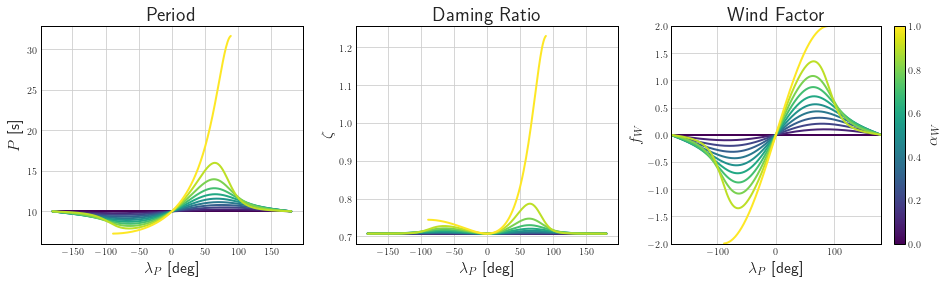

In [10]:
plot_lw = 2
cmap = plt.cm.get_cmap('viridis', len_alpW)

fig = plt.figure(figsize=(16,4))
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)

ax1 = fig.add_subplot(spec[:, 0])
ax2 = fig.add_subplot(spec[:, 1])
ax3 = fig.add_subplot(spec[:, 2])

ax1.set_title(r'Period')
ax1.set_xlabel(r'${\lambda_P}$ [deg]')
ax1.set_ylabel(r'$P$ [s]')
for i in range(len_alpW):
    ax1.plot(np.rad2deg(lP_data), P_data[i,:], linewidth=plot_lw, color=cmap(i))
# ax1.annotate(r'$P_0$', xy=(-80, P1), xytext=(-100, P1+2), arrowprops=dict(arrowstyle="->"), fontsize=14)

ax2.set_title(r'Daming Ratio')
ax2.set_xlabel(r'${\lambda_P}$ [deg]')
ax2.set_ylabel(r'$\zeta$')
for i in range(len_alpW):
    ax2.plot(np.rad2deg(lP_data), zeta_data[i,:], linewidth=plot_lw, color=cmap(i))

ax3.set_title(r'Wind Factor')
ax3.set_xlabel(r'${\lambda_P}$ [deg]')
ax3.set_ylabel(r'$f_W$')
for i in range(len_alpW):
    ax3.plot(np.rad2deg(lP_data), fW_data[i,:], linewidth=plot_lw, color=cmap(i))
ax3.set_xlim(np.rad2deg([lP_data[0], lP_data[-1]]))
ax3.set_ylim([-2, 2])

# plot dummy data to have stand alone colorbar
dummy_array = np.array([[0,1]])
dummy_plot = ax3.imshow(dummy_array, cmap='viridis')
dummy_plot.set_visible(False)
fig.colorbar(dummy_plot, ax=ax3, label=r'$\alpha_W$')

ax3.set_aspect('auto')
    
print('Wind-Aware Control Law (for an arbitrary curvature in wind)')
plt.show()

Wind-Aware Control Law (for an arbitrary curvature in wind)


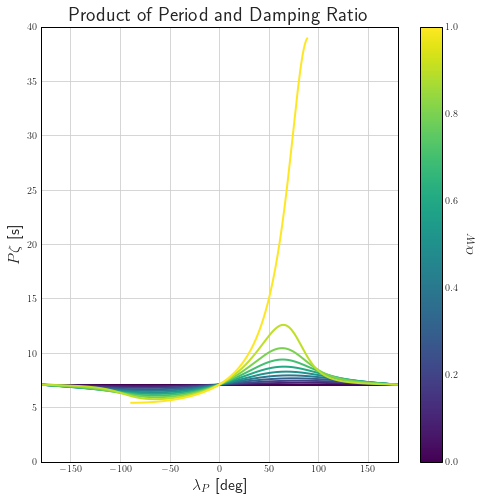

In [11]:
# where does min(P zeta) occur?

plot_lw = 2
cmap = plt.cm.get_cmap('viridis', len_alpW)

fig = plt.figure(figsize=(8,8))
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax1 = fig.add_subplot(spec[0, 0])

ax1.set_title(r'Product of Period and Damping Ratio')
ax1.set_xlabel(r'${\lambda_P}$ [deg]')
ax1.set_ylabel(r'$P \zeta$ [s]')
for i in range(len_alpW):
    ax1.plot(np.rad2deg(lP_data), P_data[i,:] * zeta_data[i,:], linewidth=plot_lw, color=cmap(i))
ax1.set_xlim(np.rad2deg([lP_data[0], lP_data[-1]]))
ax1.set_ylim([0, 40])
    
# plot dummy data to have stand alone colorbar
dummy_array = np.array([[0,1]])
dummy_plot = ax1.imshow(dummy_array, cmap='viridis')
dummy_plot.set_visible(False)
fig.colorbar(dummy_plot, ax=ax1, label=r'$\alpha_W$')

ax1.set_aspect('auto')
    
print('Wind-Aware Control Law (for an arbitrary curvature in wind)')
plt.show()

## Evaluate Dynamics for Ground Speed Based Control Law

In [12]:
len_lP = 301
len_alpW = 11

lP_data = np.linspace(-np.pi,np.pi,len_lP)
alpW_data = np.linspace(0,1,len_alpW)

a_data = np.zeros([len_alpW, len_lP])
P_gsp_data = np.zeros([len_alpW, len_lP])
zeta_gsp_data = np.zeros([len_alpW, len_lP])

vA1 = 10
kapP1 = 1/50
P1 = 10
zeta1 = 0.7071

a_expr_expanded = alpW * sp.cos(lP) / sp.sqrt(1 - alpW**2 * sp.sin(lP)**2) + 1
a_eval = sp.lambdify((alpW, lP), a_expr_expanded, 'numpy')
P_gsp_eval = sp.lambdify((P0, a), P_gsp_expr_sub, 'numpy')
zeta_gsp_eval = sp.lambdify((zeta0, a), zeta_gsp_expr_sub, 'numpy')

eps_alpW = (alpW_data[1] - alpW_data[0]) / 2
eps_lP = (lP_data[1] - lP_data[0]) / 2
for i in range(len_alpW):
    if alpW_data[i]  > 1 - eps_alpW:
        idx_sel = np.any([np.all([lP_data > (np.pi/2 - eps_lP),lP_data < (np.pi/2 + eps_lP)],axis=0),
                          np.all([lP_data > (-np.pi/2 - eps_lP),lP_data < (-np.pi/2 + eps_lP)],axis=0)], axis=0)
        a_data[i, idx_sel] = np.nan

        inv_idx_sel = ~idx_sel
        a_data[i, inv_idx_sel] = a_eval(alpW_data[i], lP_data[inv_idx_sel])
    else:
        a_data[i,:] = a_eval(alpW_data[i], lP_data)
    
    idx_neg_a = a_data[i,:] < 0
    a_data[i,idx_neg_a] = 0
    
    inv_idx_neg_a = ~idx_neg_a
    P_gsp_data[i,inv_idx_neg_a] = P_gsp_eval(P1, a_data[i,inv_idx_neg_a])
    P_gsp_data[i,idx_neg_a] = 0
    
    idx_zeta_sel = a_data[i,:] < eps_alpW
    inv_idx_zeta_sel = ~idx_zeta_sel
    zeta_gsp_data[i,inv_idx_zeta_sel] = zeta_gsp_eval(zeta1, a_data[i,inv_idx_zeta_sel])
    zeta_gsp_data[i,idx_zeta_sel] = np.nan

## Plot Period and Damping w.r.t. Speed Ratio

Ground Speed Based Control Law for Straight Paths


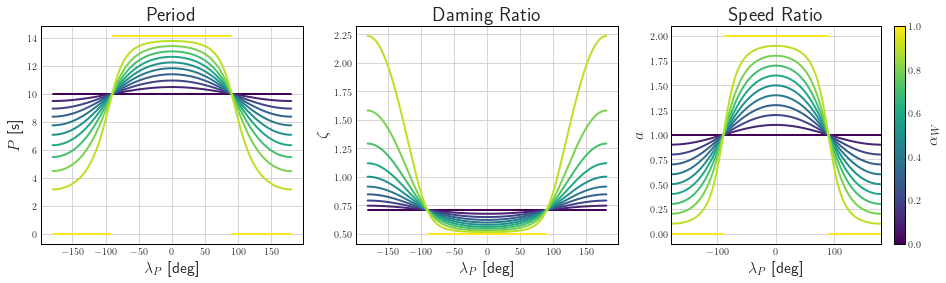

In [13]:
plot_lw = 2
cmap = plt.cm.get_cmap('viridis', len_alpW)

fig = plt.figure(figsize=(16,4))
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)

ax1 = fig.add_subplot(spec[:, 0])
ax2 = fig.add_subplot(spec[:, 1])
ax3 = fig.add_subplot(spec[:, 2])

ax1.set_title(r'Period')
ax1.set_xlabel(r'${\lambda_P}$ [deg]')
ax1.set_ylabel(r'$P$ [s]')
for i in range(len_alpW):
    ax1.plot(np.rad2deg(lP_data), P_gsp_data[i,:], linewidth=plot_lw, color=cmap(i))

ax2.set_title(r'Daming Ratio')
ax2.set_xlabel(r'${\lambda_P}$ [deg]')
ax2.set_ylabel(r'$\zeta$')
for i in range(len_alpW):
    ax2.plot(np.rad2deg(lP_data), zeta_gsp_data[i,:], linewidth=plot_lw, color=cmap(i))

ax3.set_title(r'Speed Ratio')
ax3.set_xlabel(r'${\lambda_P}$ [deg]')
ax3.set_ylabel(r'$a$')
for i in range(len_alpW):
    ax3.plot(np.rad2deg(lP_data), a_data[i,:], linewidth=plot_lw, color=cmap(i))
ax3.set_xlim(np.rad2deg([lP_data[0], lP_data[-1]]))
ax3.set_ylim([-0.1, 2.1])

# plot dummy data to have stand alone colorbar
dummy_array = np.array([[0,1]])
dummy_plot = ax3.imshow(dummy_array, cmap='viridis')
dummy_plot.set_visible(False)
fig.colorbar(dummy_plot, ax=ax3, label=r'$\alpha_W$')

ax3.set_aspect('auto')

print('Ground Speed Based Control Law for Straight Paths')
plt.show()

## Critical Wind Factor / Path Orientation
In this section, we'll determine relationships for the maximum resulting second order period, given the flight conditions.

In [14]:
# function to evaluate derivative of f w.r.t. path orientation angle lP
def eval_df(l, a):
    # inputs:
    # l         path orientation angle
    # a         wind ratio
    # outputs:
    # df/dl

    sinl = np.sin(l)
    sin2l = sinl*sinl
    cosl = np.cos(l)
    a2 = a*a
    sin4l = sin2l*sin2l
    one_m_a2sin2l = 1 - a2 * sin2l
    one_m_a2sin2l_3_2 = one_m_a2sin2l**(3/2)

    if a == 1:
        return 1 - 2 * sin2l + sin4l
    else:
        return a*(a*(a2 * sin4l - 2 * sin2l + 1) + cosl * one_m_a2sin2l_3_2) / one_m_a2sin2l_3_2


# function to evaluate f
def eval_f(l, a):
    # inputs:
    # l         path orientation angle
    # a         wind ratio
    # outputs:
    # f

    sinl = np.sin(l)
    sin2l = sinl * sinl
    cosl = np.cos(l)
    a2 = a * a
    a2sin2l = a2 * sin2l

    if a2sin2l >= 1.0:
        return 2
    else:
        return a2 * sinl * cosl / np.sqrt(1 - a2sin2l) + a * sinl


# function to evaluate critical f approximation
def eval_f_crit_analytic_approx(a):
    # inputs:
    # a         wind ratio
    # outputs:
    # fcrit

    return 2*(1 - np.sqrt(1 - a))


def eval_sum_sq_f_crit_approx_err(c, x, e):
    res = e + x.transpose().dot(c)
    return res.dot(res)

In [15]:
len_data = 501

wrd1 = np.linspace(0, 0.995, len_data - 100)
wrd2 = np.linspace(0.995, 1, 101)
wind_ratio_data = np.concatenate((wrd1[:len_data - 101], wrd2))

path_ori_crit_num_sol = np.zeros(len_data)      # numerical solution of critical path orientation per wind ratio

f_crit_analytic_approx = np.zeros(len_data)     # approximation of critical f value per wind ratio
f_crit_approx2_sol = np.zeros(len_data)         # critical f value per wind ratio
f_crit_num_sol = np.zeros(len_data)             # numerical solution of critical f value per wind ratio

### Numerically solve for critical path orientation ${\lambda_P}^\star$
The critical path orientation ${\lambda_P}^\star$ for a given wind ratio $\alpha_W$ maximizes $f_W$. To solve for this relationship we find the roots of $\frac{\partial f_W}{\partial \lambda_P}\left(\lambda_P, \alpha_W\right)=0$.

In [16]:
verbose_sol_output = False  # enable to display each solution status and value

a_solution_failed = False
for i in range(len_data):
    sol = optimize.root(eval_df, np.pi/2*0.99, args=(wind_ratio_data[i],))
    path_ori_crit_num_sol[i] = sol.x
    if verbose_sol_output:
        print(f'{wind_ratio_data[i]:.2f}' + ':' + str(sol.success) + '; sol = ' + str(sol.x))
    if not sol.success:
        a_solution_failed = True

if a_solution_failed:
    print('ERROR: One ore more numerical solutions failed, enable verbose_sol_output and re-run cell.')

# df(a=0) = 0, define a crit orientation at 0 which follows the trend of the other solutions
path_ori_crit_num_sol[0] = np.pi/2

### Numerical Solution ${f_W}^\star$

In [17]:
for i in range(len_data):
    f_crit_num_sol[i] = eval_f(path_ori_crit_num_sol[i], wind_ratio_data[i])

The numerical solution of ${\lambda_P}^\star$ and corresponding ${f_W}^\star$ are seen in the plot below.

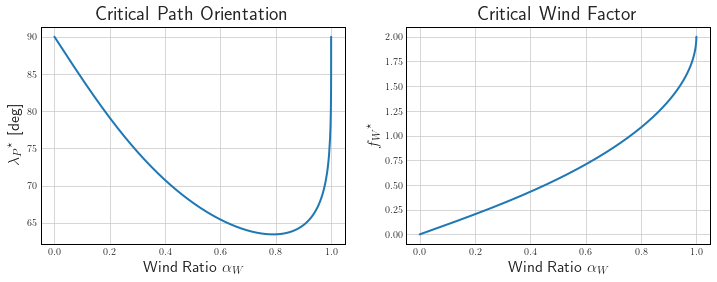

In [18]:
# plot numerical solution of critical path orientation and corresponding critical wind factor
fig = plt.figure(figsize=(12, 4))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax1 = fig.add_subplot(spec[:, 0])
ax2 = fig.add_subplot(spec[:, 1])

ax1.plot(wind_ratio_data, np.rad2deg(path_ori_crit_num_sol), linewidth=plot_lw, color='tab:blue')
ax1.set_ylabel(r'${\lambda_P}^\star$ [deg]')
ax1.set_title(r'Critical Path Orientation')
ax1.set_xlabel(r'Wind Ratio $\alpha_W$')

ax2.plot(wind_ratio_data, f_crit_num_sol, linewidth=plot_lw, color='tab:blue', label=r'Numerical Solution')
ax2.set_xlabel(r'Wind Ratio $\alpha_W$')
ax2.set_ylabel(r'${f_W}^\star$')
ax2.set_title(r'Critical Wind Factor')

plt.show()

### Approximation 1: Analytic Approx. ${\tilde{f}_W}^\star$ 

In [19]:
for i in range(len_data):
    f_crit_analytic_approx[i] = eval_f_crit_analytic_approx(wind_ratio_data[i])

f_crit_analytic_approx_err = f_crit_analytic_approx - f_crit_num_sol

### Approximation 2: Analytic Approx. + Poly3
Even though the last approximation was already quite good.. if one desires EVEN more accuracy.. we can do slightly better by fitting a 3rd order polynomial $p^{(3)}$ to our analytic approximation error $\tilde{f}_{W,\text{err}}^\star$.

$p^{(3)}\left(\mathbf{c}, \alpha_W\right) = \left({\boldsymbol{\alpha}_W}^{\circ 3}, {\boldsymbol{\alpha}_W}^{\circ 2}, {\boldsymbol{\alpha}_W}^{\circ 1}, {\boldsymbol{\alpha}_W}^{\circ 0}\right) \mathbf{c}$

where $\mathbf{c}=\left(c_3,c_2,c_1,c_0\right)^T$ are the polynomial coefficients (in decreasing order), and ${\boldsymbol{\alpha}_W}^{\circ n}$ is the set of wind ratios taken to power $n$ via Hadamard (element wise) exponential. 

The polynomial is fit using a constrainted optimization of the form

$\begin{equation}
\min_{\mathbf{c}} \left(\tilde{f}^\star_{W,\text{err}} + p^{(3)}\left(\mathbf{c}, \mathbf{\alpha}_W\right)\right)^T \left(\tilde{f}^\star_{W,\text{err}} + p^{(3)}\left(\mathbf{c},\mathbf{\alpha}_W\right)\right)
\end{equation}$

$\begin{align}
&s.t. & p^{(3)}\left(\mathbf{c}, 0\right) &= 0 & (1) \\
& & p^{(3)}\left(\mathbf{c}, 1\right) &= 0 & (2)
\end{align}$

NOTE: (1) implies c0 = 0, therefore c0 and (1) are omitted from the optimization problem.

In [20]:
wr321 = np.array([wind_ratio_data**3, wind_ratio_data**2, wind_ratio_data])
c0 = -np.array([-0.32313744, 0.31651312, 0.00662432])*0.55                          # coefficients initial guess
cons = ({'type': 'eq', 'fun': lambda c, x: x[:, -1].dot(c), 'args': (wr321,)})      # equality constraint (2)

# optimize
c_sol = optimize.minimize(eval_sum_sq_f_crit_approx_err, c0, args=(wr321, f_crit_analytic_approx_err), constraints=cons)
print(c_sol)

# calculate the polynomial result and add it to the analytic approximation
poly_fun = np.poly1d(np.concatenate((c_sol.x, np.array([0]))))
f_crit_analytic_poly_approx = f_crit_analytic_approx + poly_fun(wind_ratio_data)
f_crit_analytic_poly_approx_err = f_crit_analytic_poly_approx - f_crit_num_sol

     fun: 5.622576748976453e-05
     jac: array([0.07341382, 0.07341382, 0.07341382])
 message: 'Optimization terminated successfully'
    nfev: 18
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ 0.1705916 , -0.15937888, -0.01121272])


Next we compare the solutions and approximations for the critical wind factor ${f_W}^\star$

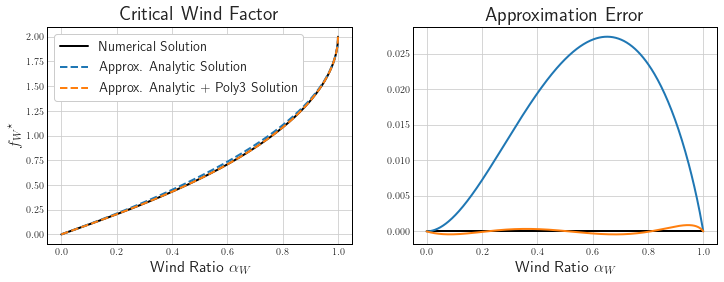

In [21]:
fig = plt.figure(figsize=(12, 4))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax1 = fig.add_subplot(spec[:, 0])
ax2 = fig.add_subplot(spec[:, 1])

ax1.plot(wind_ratio_data, f_crit_num_sol, linewidth=plot_lw, color='black', label=r'Numerical Solution')
ax1.plot(wind_ratio_data, f_crit_analytic_approx, '--', linewidth=plot_lw, color='tab:blue', label=r'Approx. Analytic Solution')
ax1.plot(wind_ratio_data, f_crit_analytic_poly_approx, '--', linewidth=plot_lw, color='tab:orange', label=r'Approx. Analytic + Poly3 Solution')
ax1.set_ylabel(r'${f_W}^\star$')
ax1.set_title(r'Critical Wind Factor')
ax1.set_xlabel(r'Wind Ratio $\alpha_W$')
ax1.legend(loc="upper left")

ax2.plot([wind_ratio_data[i] for i in [0, -1]], [0, 0], linewidth=plot_lw, color='black')
ax2.plot(wind_ratio_data, f_crit_analytic_approx_err, linewidth=plot_lw, color='tab:blue')
ax2.plot(wind_ratio_data, f_crit_analytic_poly_approx_err, linewidth=plot_lw, color='tab:orange')
ax2.set_title(r'Approximation Error')
# ax2.set_ylabel(r'${f_W}^\star$ Error')
ax2.set_xlabel(r'Wind Ratio $\alpha_W$')

plt.show()

## Upper and Lower Bounds for Choice of $P_0$

In [22]:
# XXX should make functions array capable..

def evalfWCrit(alpW):
    if alpW <= 0:
        return 0
    elif alpW <= 1:
        return 2*(1 - np.sqrt(1 - alpW))
    else:
        return 2
        

def P0UpperBound(zeta0, omA, alpW):
    
    fW = evalfWCrit(alpW)
    
    eps = 0.001
    if np.abs(fW * omA) < eps:
        
        return np.nan
    
    else:
        
        if zeta0 >= np.sqrt(2)/2:
            return np.pi / (zeta0 * omA * fW)
        else:
            return 4 * np.pi * zeta0 / (omA * fW)
    
    
def P0LowerBound(zeta0, omA, alpW, tauRoll):
    
    eps = 0.001
    
    fW = evalfWCrit(alpW)
    fWomA = fW * omA
    
    if np.abs(fWomA) < eps:
        return np.pi*tauRoll/zeta0
    else:
        return 2*np.pi * ( np.sqrt( zeta0**2 * (fWomA * tauRoll - 1)**2 + fWomA*tauRoll ) \
                          + zeta0 * (fWomA*tauRoll - 1) ) / fWomA
    

len_omA = 301
len_alpW = 11

omA_data = np.linspace(0,15/1,len_omA)
alpW_data = np.linspace(0,1,len_alpW)
tauR_data = np.array([0.5, 1.0, 2.0])
len_tauR = len(tauR_data)

P_upper_data = np.zeros([len_alpW, len_omA])
P_lower_data = np.zeros([len_tauR, len_alpW, len_omA])

zeta1 = 0.7071

for i in range(len_omA):
    
    for j in range(len_alpW):
        
        P_upper_data[j,i] = P0UpperBound(zeta1, omA_data[i], alpW_data[j])
        
        for l in range(len_tauR):
            
            P_lower_data[l,j,i] = P0LowerBound(zeta1, omA_data[i], alpW_data[j], tauR_data[l])

# mask arrays
P_upper_data_ext = np.tile(P_upper_data, (len_tauR,1,1,))
P_upper_data_left = np.ma.masked_where(P_upper_data_ext < P_lower_data, P_upper_data_ext)
P_lower_data_left = np.ma.masked_where(P_lower_data > P_upper_data_ext, P_lower_data)
P_upper_data_right = np.ma.masked_where(P_upper_data_ext >= P_lower_data, P_upper_data_ext)
P_lower_data_right = np.ma.masked_where(P_lower_data <= P_upper_data_ext, P_lower_data)

Tuning Bounds for Wind-Aware Control Law


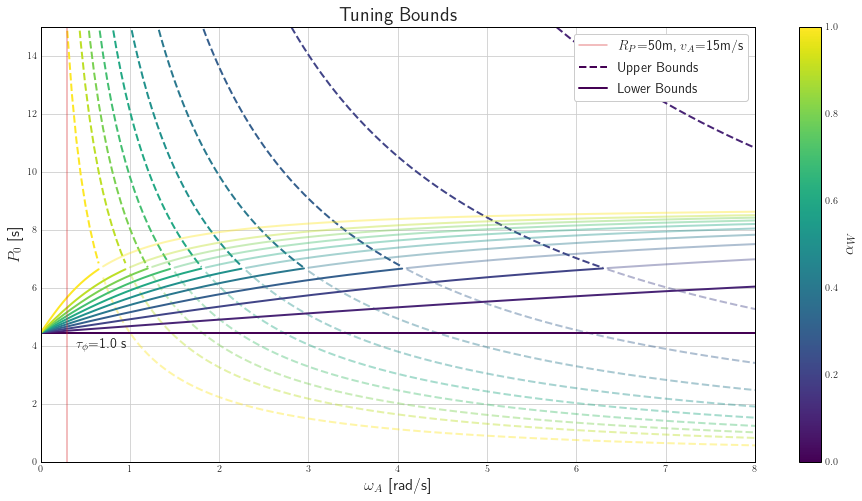

In [23]:
cmap = plt.cm.get_cmap('viridis', len_alpW)
alpha_plot = 0.4

fig = plt.figure(figsize=(16,8))
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax1 = fig.add_subplot(spec[:, 0])
# ax2 = fig.add_subplot(spec[:, 1])

ax1.set_title(r'Tuning Bounds')
ax1.set_xlabel(r'${\omega_A}$ [rad/s]')
ax1.set_ylabel(r'$P_0$ [s]')
ax1.set_xlim([omA_data[0], 8])#omA_data[-1]])
ax1.set_xlim([omA_data[0], 8])#omA_data[-1]])
ax1.set_ylim([0, 15])

idx_tauR = 1

for i in range(len_alpW):
    ax1.plot(omA_data, P_upper_data_left[idx_tauR,i,:], linewidth=plot_lw, color=cmap(i), linestyle='--')
    ax1.plot(omA_data, P_upper_data_right[idx_tauR,i,:], linewidth=plot_lw, color=cmap(i), linestyle='--', alpha=alpha_plot)

for i in range(len_alpW):
    ax1.plot(omA_data, P_lower_data_left[idx_tauR,i,:], linewidth=plot_lw, color=cmap(i))
    ax1.plot(omA_data, P_lower_data_right[idx_tauR,i,:], linewidth=plot_lw, color=cmap(i), alpha=alpha_plot)
ax1.text(0.4, P_lower_data[idx_tauR,i,0]-0.5, r'$\tau_\phi$=%.1f s' %tauR_data[idx_tauR], fontsize=14)

ax1.plot([15/50, 15/50], [0, 20], color='tab:red', alpha=alpha_plot, label=r'$R_P$=50m, $v_A$=15m/s')

# plot dummy data for legend
dummy_data = np.array([np.nan, np.nan])
dummy_plot_upper = ax1.plot(dummy_data, dummy_data, linewidth=plot_lw, linestyle='--', color=cmap(0), label=r'Upper Bounds')
dummy_plot_lower = ax1.plot(dummy_data, dummy_data, linewidth=plot_lw, color=cmap(0), label=r'Lower Bounds')

ax1.legend(loc='upper right')

# plot dummy data to have stand alone colorbar
dummy_array = np.array([[0,1]])
dummy_image = ax1.imshow(dummy_array, cmap='viridis')
dummy_image.set_visible(False)
fig.colorbar(dummy_image, ax=ax1, label=r'$\alpha_W$')

ax1.set_aspect('auto')
    
# save pdf
if False:
    plt.savefig('p0_tuning_bounds.pdf')
    
print('Tuning Bounds for Wind-Aware Control Law')
plt.show()

In [50]:
def evalUncDyn(n, b, P0, zeta0, dvW, dl, kapP, lP, vA, vW):
    
    k = 4*np.pi*zeta0 / P0
    T = P0 * zeta0
    
    ll = b + lP
    
    xl = np.arcsin(vW / vA * np.sin(ll))
    
    psi = b - n + lP + xl
    
    vG = np.sqrt(vA**2 + vW**2 - 2*vA*vW*np.cos(np.pi - psi))
    
    x = np.arccos((vA**2 - vW**2 + vG**2) / (2 * vA * vG))
    
    n_P = n - b + x - xl
    
    vGl = vW * np.cos(ll) + vA * np.cos(xl)
    
    e = -b * vG * T / np.pi
    
    omP = kapP * vG * np.cos(n_P) / (1 - kapP * e)
    
    vWt = vW + dvW
    lt = ll + xl - n - x + dl
    vAt = np.sqrt(vWt**2 + vG**2 - 2*vWt*vG*np.cos(lt))
    xt = np.arcsin(vWt / vAt * np.sin(lt))
    llt = b + lP + dl
    xlt = np.arcsin(vWt / vAt * np.sin(llt))
    nt = n - x + xt - xl + xlt
    vGlt = vWt * np.cos(llt) + vAt * np.cos(xlt)
    
    psidot = k * np.sin(nt) + vGlt / vAt / np.cos(xlt) * omP
        
    vGdot = -vA*vW*np.sin(psi) / vG * psidot
    
    bdot = -b * vGdot / vG + np.pi / T * np.sin(n_P)
   
    ndot = -psidot + vGl / vA / np.cos(xl) * (bdot + omP)

    return ndot, bdot


def evalUncNumJac(n0, b0, P0, zeta0, dvW, dl, kapP, lP, vA, vW):
    
    dn = 0.000001
    db = 0.000001
    twod = dn*2

    dndot_dn_p, dbdot_dn_p = evalDyn(n0 + dn, b0, P0, zeta0, dvW, dl, kapP, lP, vA, vW)
    dndot_dn_m, dbdot_dn_m = evalDyn(n0 - dn, b0, P0, zeta0, dvW, dl, kapP, lP, vA, vW)
    dndot_db_p, dbdot_db_p = evalDyn(n0, b0 + db, P0, zeta0, dvW, dl, kapP, lP, vA, vW)
    dndot_db_m, dbdot_db_m = evalDyn(n0, b0 - db, P0, zeta0, dvW, dl, kapP, lP, vA, vW)
    
    dndot_dn = (dndot_dn_p - dndot_dn_m) / twod
    dndot_db = (dndot_db_p - dndot_db_m) / twod
    dbdot_dn = (dbdot_dn_p - dbdot_dn_m) / twod
    dbdot_db = (dbdot_db_p - dbdot_db_m) / twod
    
    return np.array([dndot_dn, dndot_db, dbdot_dn, dbdot_db])


n1 = 0.0
b1 = 0.0
P1 = 10
zeta1 = 0.7071
kapP1 = 0 * 1.0 / 50.0
lP1 = 0
vA1 = 15.0
vW1 = 0

len_dvW = 11
len_dl = 101

dvW_data = np.linspace(0,15,len_dvW)
dl_data = np.linspace(-np.pi,np.pi,len_dl)

ndot0_data = np.zeros([len_dvW,len_dl])
bdot0_data = np.zeros([len_dvW,len_dl])

for i in range(len_dvW):
    for j in range(len_dl):
        ndot0_data[i,j], bdot0_data[i,j] = evalUncDyn(n1, b1, P1, zeta1, dvW_data[i], dl_data[j], kapP1, lP1, vA1, vW1)

<ipython-input-50-4c192f988e8b>:27: RuntimeWarning: divide by zero encountered in double_scalars
  xt = np.arcsin(vWt / vAt * np.sin(lt))
<ipython-input-50-4c192f988e8b>:27: RuntimeWarning: invalid value encountered in arcsin
  xt = np.arcsin(vWt / vAt * np.sin(lt))
<ipython-input-50-4c192f988e8b>:29: RuntimeWarning: divide by zero encountered in double_scalars
  xlt = np.arcsin(vWt / vAt * np.sin(llt))
<ipython-input-50-4c192f988e8b>:29: RuntimeWarning: invalid value encountered in arcsin
  xlt = np.arcsin(vWt / vAt * np.sin(llt))


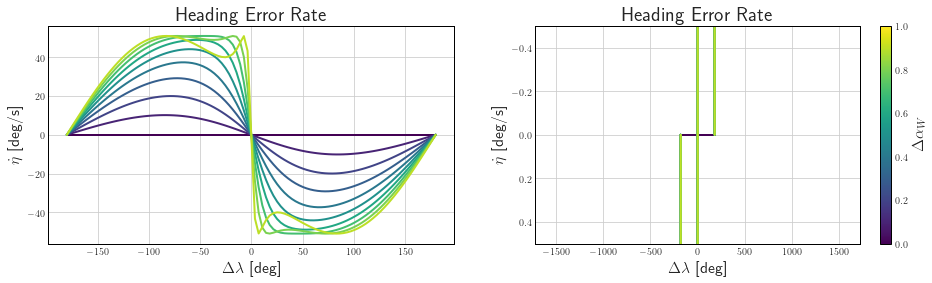

In [52]:
cmap = plt.cm.get_cmap('viridis', len_dvW)

fig = plt.figure(figsize=(16,4))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax1 = fig.add_subplot(spec[:, 0])
ax2 = fig.add_subplot(spec[:, 1])

ax1.set_title(r'Heading Error Rate')
ax1.set_xlabel(r'${\Delta\lambda}$ [deg]')
ax1.set_ylabel(r'$\dot{\eta}$ [deg/s]')
for i in range(len_dvW-1):
    ax1.plot(np.rad2deg(dl_data), np.rad2deg(ndot0_data[i,:]), linewidth=plot_lw, color=cmap(i))

ax2.set_title(r'Heading Error Rate')
ax2.set_xlabel(r'${\Delta\lambda}$ [deg]')
ax2.set_ylabel(r'$\dot{\eta}$ [deg/s]')
for i in range(len_dvW-1):
    ax2.plot(np.rad2deg(dl_data), np.rad2deg(ndot0_data[i,:]), linewidth=plot_lw, color=cmap(i))
ax2.set_xlim(np.rad2deg([-30, 30]))
ax2.set_ylim()

# plot dummy data to have stand alone colorbar
dummy_array = np.array([[0,1]])
dummy_plot = ax2.imshow(dummy_array, cmap='viridis')
dummy_plot.set_visible(False)
fig.colorbar(dummy_plot, ax=ax2, label=r'$\Delta \alpha_W$')

ax2.set_aspect('auto')
    
plt.show()